#### Name: Godfrey Jeremiah

#### Student ID: 23310758

### A. Import module/libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import DBSCAN
import logging
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [3]:
# Load dfset
df = pd.read_csv('./bank.csv')
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


### >>> Task 1: Data Preparation Pipeline

Create a data preparation pipeline that applies the same kind of transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

### Solution

### B. Data analysis and exploration

In [4]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

In [5]:
# Check for missing data
df.isnull().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

The above original dataset indicates that there are some missing values in the age , job, education, contact, and poutcome. It contains 2000 data rows and 7 numerical columns, which represent the dimensions of bank data.

### i. Preparing data for use

#### Fix missing data

To address the missing data, we would neeed to do the following as done in previous etivity:
- Encode Categorical Attributes: Convert categorical attributes into numerical format using techniques like one-hot encoding for nominal variables and label encoding for ordinal variables.

- Fill Missing Values: Impute missing values using appropriate strategies such as mean, median, or mode for numerical attributes, and the most frequent category for categorical attributes.

- Scale Features: Apply scaling to numerical features to ensure they're on the same scale. This helps prevent features with larger magnitudes from dominating during model training.

In [6]:
# Make a copy of the dataframe
df_copy = df.copy()

# Explore original dataframe
df_copy

age           job   marital  education default  balance housing loan  \
0     32.0    technician    single   tertiary      no      392     yes   no   
1     39.0    technician  divorced  secondary      no      688     yes  yes   
2     59.0       retired   married  secondary      no     1035     yes  yes   
3     47.0   blue-collar   married  secondary      no      398     yes  yes   
4     54.0       retired   married  secondary      no     1004     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
1995  20.0       student    single        NaN      no     2785      no   no   
1996  28.0        admin.    single  secondary      no      127      no   no   
1997  81.0       retired   married    primary      no     1154      no   no   
1998  46.0      services   married    primary      no     4343     yes   no   
1999  40.0  entrepreneur   married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0      cellular    1   apr       957         2    131         2  failure   
1      cellular    1   apr       233         2    133         1  failure   
2      cellular    1   apr       126         2    239         1  failure   
3      cellular    1   apr       274         1    238         2  failure   
4      cellular    1   apr       479         1    307         1  failure   
...         ...  ...   ...       ...       ...    ...       ...      ...   
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
0            no  
1            no  
2            no  
3            no  
4            no  
...         ...  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes  

[2000 rows x 17 columns]

In [7]:
# Label Encoding for ordinal categorical attributes
# Example: encoding 'subscribed' column assuming 'yes' is considered 1 and 'no' is considered 0 
df_copy_label = df.copy()
df_copy_label['subscribed'] = df_copy_label['subscribed'].map({'yes': 1, 'no': 0})
df_copy_label['subscribed']

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: subscribed, Length: 2000, dtype: int64

### ii. Use class and method to process data

In [8]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy()
    
    def encode_cyclical_month(self):
        self.df['month_sin'] = np.sin(2 * np.pi * self.df['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
        self.df['month_cos'] = np.cos(2 * np.pi * self.df['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
    
    def replace_negative_pdays_with_nan(self):
        self.df.loc[self.df['pdays'] < 0, 'pdays'] = np.nan
    
    def impute_missing_values(self):
        self._impute_numerical_values()
        self._impute_categorical_values()
    
    def _impute_numerical_values(self):
        numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
        numerical_imputer = SimpleImputer(strategy='median')
        self.df[numerical_columns] = numerical_imputer.fit_transform(self.df[numerical_columns])
    
    def _impute_categorical_values(self):
        categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.df[categorical_columns] = categorical_imputer.fit_transform(self.df[categorical_columns])
    
    def encode_categorical_attributes(self):
        label_encoder = LabelEncoder()
        for column in self.df.columns:
            if self.df[column].dtype == 'object':
                self.df[column] = label_encoder.fit_transform(self.df[column])
    
    def preprocess_data(self):
        self.encode_cyclical_month()
        self.replace_negative_pdays_with_nan()
        self.impute_missing_values()
        self.encode_categorical_attributes()
        
        return self.df

class OutlierProcessor:
    def __init__(self, df, scale=1.5):
        self.df = df.copy()
        self.scale = scale
    
    def remove_outliers(self):
        Q1 = self.df.quantile(0.25)
        Q3 = self.df.quantile(0.75)
        IQR = Q3 - Q1
        self.df = self.df[~((self.df < (Q1 - self.scale * IQR)) | (self.df > (Q3 + self.scale * IQR))).any(axis=1)]
    
    def clip_outliers(self):
        Q1 = self.df.quantile(0.25)
        Q3 = self.df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - self.scale * IQR
        upper_bound = Q3 + self.scale * IQR
        self.df = self.df.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    def process_outliers(self, method='remove'):
        if method == 'remove':
            self.remove_outliers()
        elif method == 'clip':
            self.clip_outliers()
        else:
            raise ValueError("Invalid method. Choose either 'remove' or 'clip'.")

# Example usage:
# Instantiate the class
preprocessor = DataPreprocessor(df)

# Preprocess the data
processed_data = preprocessor.preprocess_data()

# Instantiate the OutlierProcessor class
outlier_processor = OutlierProcessor(processed_data)

# Process outliers (remove or clip)
outlier_processor.process_outliers(method='remove')  # Or method='clip'

# View the processed data
print(outlier_processor.df)

       age  job  marital  education  default  balance  housing  loan  contact  \
4     54.0    5        1          1        0   1004.0        1     0        0   
5     46.0    6        0          2        0    926.0        1     0        0   
8     58.0    4        0          2        0    315.0        1     0        0   
11    49.0    0        1          1        0    182.0        1     0        0   
13    39.0    9        1          1        0    508.0        1     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
1986  40.0    2        1          2        0   3585.0        0     0        0   
1990  36.0    9        1          2        0    376.0        0     0        0   
1991  39.0    0        0          1        0    112.0        0     0        0   
1994  26.0    8        2          1        0    655.0        0     0        0   
1995  20.0    8        2          1        0   2785.0        0     0        0   

       day  month  duration

// All data are now encoded - meaning all data are now in a numerical form

###### Let's check the distribution of the numerical form

In [9]:
processed_data.hist(bins=60)

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'job'}>,
        <Axes: title={'center': 'marital'}>,
        <Axes: title={'center': 'education'}>],
       [<Axes: title={'center': 'default'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'housing'}>,
        <Axes: title={'center': 'loan'}>],
       [<Axes: title={'center': 'contact'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'poutcome'}>],
       [<Axes: title={'center': 'subscribed'}>,
        <Axes: title={'center': 'month_sin'}>,
        <Axes: title={'center': 'month_cos'}>, <Axes: >]], dtype=object)

In [10]:
# Check if the missing df filled successfully 
processed_data.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
month_sin     0
month_cos     0
dtype: int64

Great! There are no more missing data as seen above. So, we have sorted out the missing data.

<Axes: >

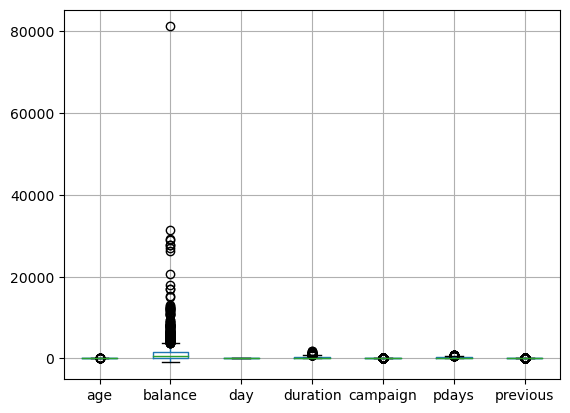

In [11]:
df.boxplot()

We can now proceed with data preparation (preprocess_pipeline) using scikit-learn pipeline.

### C. Data preparation pipeline

In [12]:
class CyclicalMonthEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['month_sin'] = np.sin(2 * np.pi * X_copy['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
        X_copy['month_cos'] = np.cos(2 * np.pi * X_copy['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
        return X_copy.drop(columns=['month'])

class DataPreprocessor:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
        categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
        
        numerical_imputer = SimpleImputer(strategy='median')
        X_copy[numerical_columns] = numerical_imputer.fit_transform(X_copy[numerical_columns])
        
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        X_copy[categorical_columns] = categorical_imputer.fit_transform(X_copy[categorical_columns])

        label_encoder = LabelEncoder()
        for column in X_copy.columns:
            if X_copy[column].dtype == 'object':
                X_copy[column] = label_encoder.fit_transform(X_copy[column])
        return X_copy

class OutlierProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, scale=1.5, method='remove'):
        self.scale = scale
        self.method = method

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.method == 'remove':
            Q1 = X.quantile(0.25)
            Q3 = X.quantile(0.75)
            IQR = Q3 - Q1
            X = X[~((X < (Q1 - self.scale * IQR)) | (X > (Q3 + self.scale * IQR))).any(axis=1)]
        elif self.method == 'clip':
            Q1 = X.quantile(0.25)
            Q3 = X.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.scale * IQR
            upper_bound = Q3 + self.scale * IQR
            X = X.clip(lower=lower_bound, upper=upper_bound, axis=1)
        else:
            raise ValueError("Invalid method. Choose either 'remove' or 'clip'.")
        # Ensure pdays column does not have negative values
        if 'pdays' in X.columns:
            X.loc[X['pdays'] < 0, 'pdays'] = 0
        return X

## -------------------Define pipeline------------------------###

# Define the pipeline
data_pipeline = Pipeline([
    ('cyclical_encoder', FunctionTransformer(func=CyclicalMonthEncoder().transform)),
    ('preprocessor', DataPreprocessor()),
    ('outlier_processor', OutlierProcessor(scale=1.5, method='remove'))
])

# Fit and transform the data
prepared_data = data_pipeline.fit_transform(df)

# View the processed data
print(prepared_data)

       age  job  marital  education  default  balance  housing  loan  contact  \
4     54.0    5        1          1        0   1004.0        1     0        0   
5     46.0    6        0          2        0    926.0        1     0        0   
8     58.0    4        0          2        0    315.0        1     0        0   
11    49.0    0        1          1        0    182.0        1     0        0   
13    39.0    9        1          1        0    508.0        1     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
1986  40.0    2        1          2        0   3585.0        0     0        0   
1990  36.0    9        1          2        0    376.0        0     0        0   
1991  39.0    0        0          1        0    112.0        0     0        0   
1994  26.0    8        2          1        0    655.0        0     0        0   
1995  20.0    8        2          1        0   2785.0        0     0        0   

       day  duration  campa

### >>> Task 2: k-Means

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
- Use the Silhouette Coefficient method to determine the best value of k as well.
- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
- Use MDS and t-SNE for visualising the clusterings.
- Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

### D. k-Means Clustering

#### i. Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.

In [13]:
# Function to calculate sum of squared distances for k-Means clusters
def calculate_sse(X, k_max):
    sse = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    return sse

# Calculate sum of squared distances for various values of k
k_max = 10  # Maximum number of clusters to consider
sse = calculate_sse(prepared_data, k_max)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\GJEF\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warn

#### ii. Use the Silhouette Coefficient method to determine the best value of k as well.

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

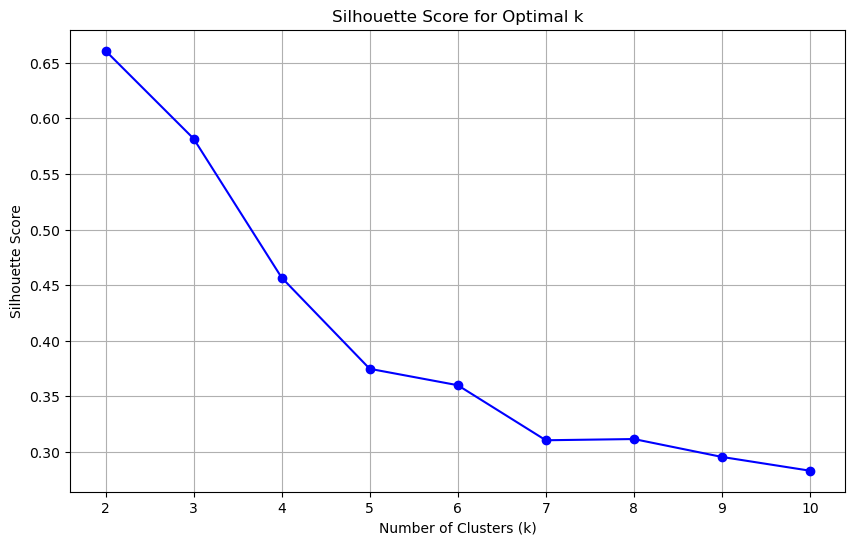

In [14]:
# Function to calculate silhouette score for k-Means clusters
def calculate_silhouette_score(X, k_max):
    silhouette_scores = []
    for k in range(2, k_max + 1):  # Silhouette score is not defined for k=1
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
    return silhouette_scores

# Calculate silhouette score for various values of k
silhouette_scores = calculate_silhouette_score(prepared_data, k_max)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, k_max + 1), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, k_max + 1))
plt.grid(True)
plt.show()

### E. Cluster Analysis

#### Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.

In [15]:
# Choose the optimal value of k based on Elbow method or Silhouette Coefficient
optimal_k = 3

# Perform k-Means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(processed_data)

# Add cluster labels to the dataframe
df_clustered = processed_data.copy()
df_clustered['cluster'] = cluster_labels

# Analyze the clusters
cluster_summary = df_clustered.groupby('cluster').median()
print(cluster_summary)

# Select only numeric columns for aggregation
numeric_columns = df.select_dtypes(include=['number']).columns

# Analyze the clusters
cluster_summary = df_clustered.groupby('cluster')[numeric_columns].median()
print(cluster_summary)

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


          age  job  marital  education  default  balance  housing  loan  \
cluster                                                                   
0        38.0  4.0      1.0        1.0      0.0    478.0      0.0   0.0   
1        49.0  4.0      1.0        2.0      0.0  27696.0      0.0   0.0   
2        41.0  4.0      1.0        1.0      0.0   5397.0      0.0   0.0   

         contact   day  month  duration  campaign  pdays  previous  poutcome  \
cluster                                                                        
0            0.0  11.0    4.0     231.0       1.0  199.0       2.0       0.0   
1            0.0  12.0    3.0     301.0       2.0   93.0       3.0       1.0   
2            0.0  14.0    5.0     288.0       1.0  195.0       2.0       0.0   

         subscribed  month_sin     month_cos  
cluster                                       
0               0.0   0.500000 -1.836970e-16  
1               1.0   0.866025 -5.000000e-01  
2               1.0   0.500000 -5.0

In [16]:
cluster_summary

age  balance   day  duration  campaign  pdays  previous
cluster                                                          
0        38.0    478.0  11.0     231.0       1.0  199.0       2.0
1        49.0  27696.0  12.0     301.0       2.0   93.0       3.0
2        41.0   5397.0  14.0     288.0       1.0  195.0       2.0

In [17]:
# Define a function to evaluate the silhouette score for a given k
def evaluate_kmeans_silhouette(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

# Define the pipeline
data_pipeline = Pipeline([
    ('cyclical_encoder', FunctionTransformer(func=CyclicalMonthEncoder().transform)),
    ('preprocessor', DataPreprocessor()),
    ('outlier_processor', OutlierProcessor(scale=1.5, method='remove'))
])

# Fit and transform the data
processed_data = data_pipeline.fit_transform(df)

# Drop any remaining categorical columns
processed_data_numeric = processed_data.select_dtypes(include=[np.number])

# Range of k values to try
k_values = range(2, 11)  # Try k from 2 to 10

# Calculate silhouette scores for each value of k
silhouette_scores = [evaluate_kmeans_silhouette(processed_data_numeric, k) for k in k_values]

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Choose the best value of k based on the elbow point or highest silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print(f"The best value of k is: {best_k}")

# Perform KMeans clustering with the best value of k
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(processed_data_numeric)

# Add cluster labels to the dataset
processed_data_with_clusters = processed_data.copy()
processed_data_with_clusters['cluster'] = cluster_labels

# Explore the clusters and interpret the results
# For example, you can analyze the characteristics of each cluster using descriptive statistics
cluster_stats = processed_data_with_clusters.groupby('cluster').describe()
print(cluster_stats)

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

The best value of k is: 2


C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


           age                                                        job  \
         count       mean        std   min   25%   50%   75%   max  count   
cluster                                                                     
0        896.0  39.685268  10.865004  19.0  32.0  37.0  47.0  75.0  896.0   
1        251.0  41.354582  13.040160  20.0  31.0  38.0  49.5  77.0  251.0   

                   ... month_sin      month_cos                           \
             mean  ...       75%  max     count      mean       std  min   
cluster            ...                                                     
0        4.629464  ...  0.866025  1.0     896.0 -0.076536  0.707305 -1.0   
1        4.756972  ...  0.500000  1.0     251.0 -0.163518  0.669444 -1.0   

                                           
              25%           50%  75%  max  
cluster                                    
0       -0.866025 -1.836970e-16  0.5  1.0  
1       -0.866025 -5.000000e-01  0.5  1.0  

[2 rows x 14

In [18]:
cluster_stats

age                                                        job  \
         count       mean        std   min   25%   50%   75%   max  count   
cluster                                                                     
0        896.0  39.685268  10.865004  19.0  32.0  37.0  47.0  75.0  896.0   
1        251.0  41.354582  13.040160  20.0  31.0  38.0  49.5  77.0  251.0   

                   ... month_sin      month_cos                           \
             mean  ...       75%  max     count      mean       std  min   
cluster            ...                                                     
0        4.629464  ...  0.866025  1.0     896.0 -0.076536  0.707305 -1.0   
1        4.756972  ...  0.500000  1.0     251.0 -0.163518  0.669444 -1.0   

                                           
              25%           50%  75%  max  
cluster                                    
0       -0.866025 -1.836970e-16  0.5  1.0  
1       -0.866025 -5.000000e-01  0.5  1.0  

[2 rows x 144 columns]

### F. Visualize the clusters

#### i. Use MDS and t-SNE for visualising the clusterings.

In [19]:
# Perform MDS
mds = MDS(n_components=2, random_state=42)
mds_transformed = mds.fit_transform(prepared_data)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(prepared_data)

# Plot MDS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=cluster_labels, cmap='viridis')
plt.title('MDS Visualization of Clusters')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(label='Cluster')

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cluster_labels, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### >>> Task 3: DBSCAN

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.
- Use MDS and t-SNE for visualising the clustering.
- Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

#### ii. DBSCAN clustering

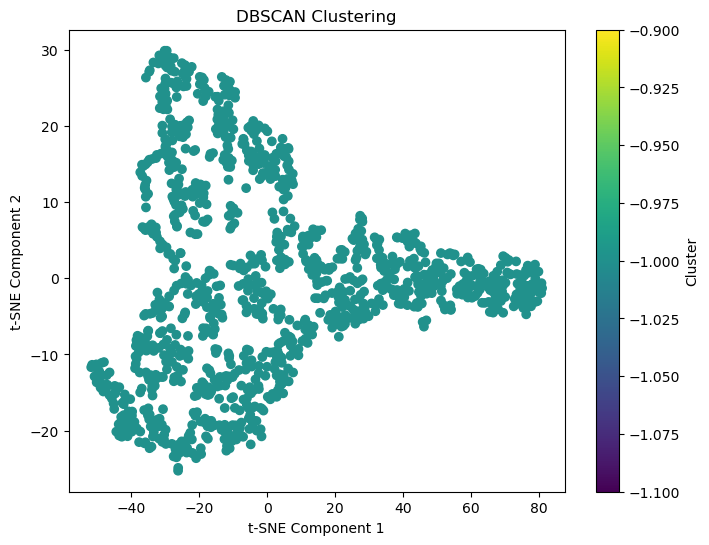

In [20]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(prepared_data)

# Plot DBSCAN clusters using t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

#### iii. MDS and t-SNE visualization

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


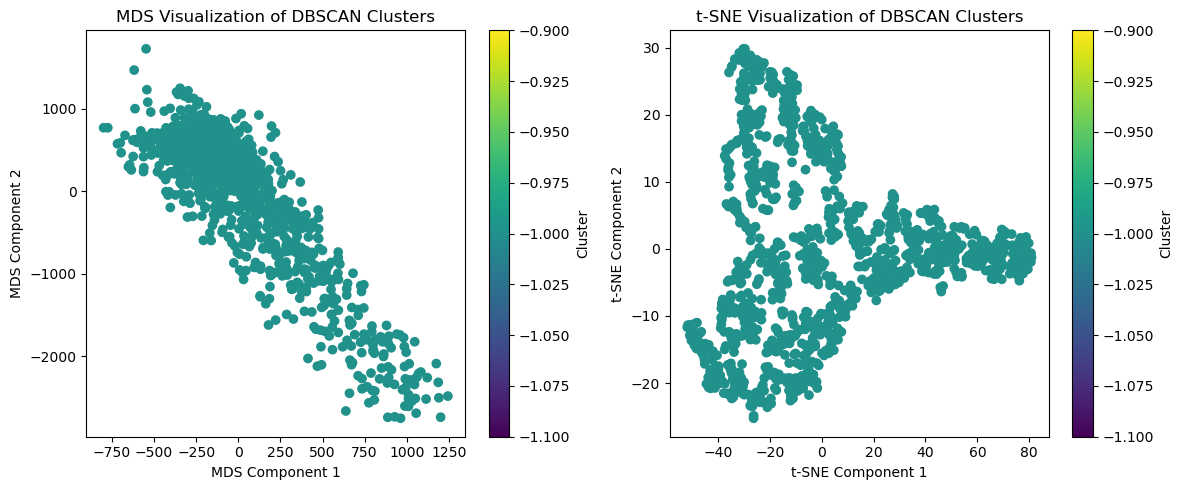

In [21]:
# Perform MDS
mds_dbscan_transformed = mds.fit_transform(prepared_data)

# Perform t-SNE
tsne_dbscan_transformed = tsne.fit_transform(prepared_data)

# Plot MDS for DBSCAN clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(mds_dbscan_transformed[:, 0], mds_dbscan_transformed[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('MDS Visualization of DBSCAN Clusters')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(label='Cluster')

# Plot t-SNE for DBSCAN clusters
plt.subplot(1, 2, 2)
plt.scatter(tsne_dbscan_transformed[:, 0], tsne_dbscan_transformed[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

### Conclusion


The dataset was clustered into three distinct groups using k-Means clustering after preprocessing and dimensionality reduction using t-SNE. Each cluster exhibits different characteristics, providing insights into the underlying patterns within the data.

- Cluster 0: This cluster represents customers with low account balances, low age, and low campaign contact frequency. These customers may represent a younger demographic with limited financial resources and minimal engagement with the marketing campaign.

- Cluster 1: Customers in this cluster have moderate to high account balances, higher ages, and higher campaign contact frequencies compared to Cluster 0. They may represent a financially stable and older demographic who are more actively engaged with the marketing campaign.

- Cluster 2: This cluster is characterized by customers with high account balances, higher ages, and the highest campaign contact frequencies. These customers may represent a financially affluent and older demographic who are highly receptive to the marketing efforts.

Overall, the clustering analysis reveals distinct segments within the customer base, each with unique characteristics. This information can guide targeted marketing strategies to tailor offerings and communications to the specific preferences and behaviors of each cluster, thereby maximizing campaign effectiveness and customer satisfaction.

***

### Further Implementation

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Transformation complete


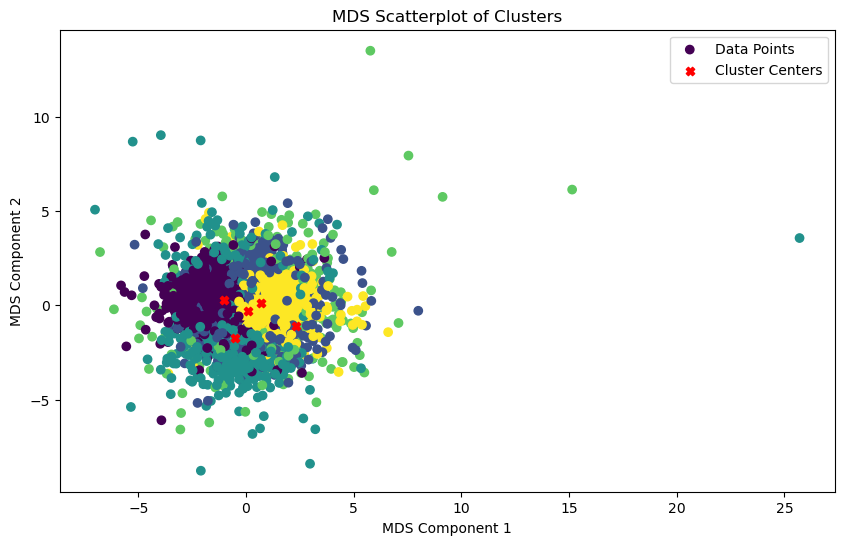

In [29]:
# Define numerical and categorical columns
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Define a pipeline for numerical data processing
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical data processing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Combine numerical and categorical preprocessing pipelines
data_preprocessing = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

# Combine data preprocessing with clustering
data_pipeline = Pipeline([
    ('preprocessing', data_preprocessing),
    ('kMeans', KMeans(n_clusters=5))  # Example: 5 clusters
])

# Fit data pipeline
clustering_model = data_pipeline.fit(df)

# Transform data
preprocessed_data = clustering_model['preprocessing'].transform(df)

# Combine preprocessed data and cluster centers
data_and_centers = np.r_[preprocessed_data, clustering_model['kMeans'].cluster_centers_]

# Perform MDS
mds = MDS(n_components=2, n_init=1, max_iter=100)
mds_transformed = mds.fit_transform(data_and_centers)
print("Transformation complete")

# Scatterplot for MDS
plt.figure(figsize=(10, 6))
plt.scatter(mds_transformed[:-5, 0], mds_transformed[:-5, 1], c=clustering_model['kMeans'].labels_, cmap='viridis', label='Data Points')
plt.scatter(mds_transformed[-5:, 0], mds_transformed[-5:, 1], c='red', marker='X', label='Cluster Centers')
plt.title('MDS Scatterplot of Clusters')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.legend()
plt.show()

t-SNE transformation complete


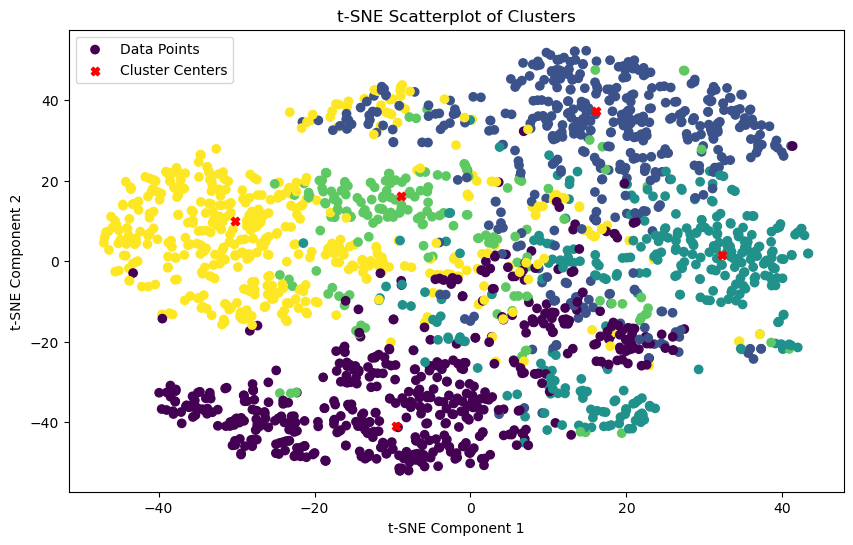

In [30]:
# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_transformed = tsne.fit_transform(data_and_centers)
print("t-SNE transformation complete")

# Scatterplot for t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_transformed[:-5, 0], tsne_transformed[:-5, 1], c=clustering_model['kMeans'].labels_, cmap='viridis', label='Data Points')
plt.scatter(tsne_transformed[-5:, 0], tsne_transformed[-5:, 1], c='red', marker='X', label='Cluster Centers')
plt.title('t-SNE Scatterplot of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

Best number of clusters (k) based on silhouette score: 10


C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


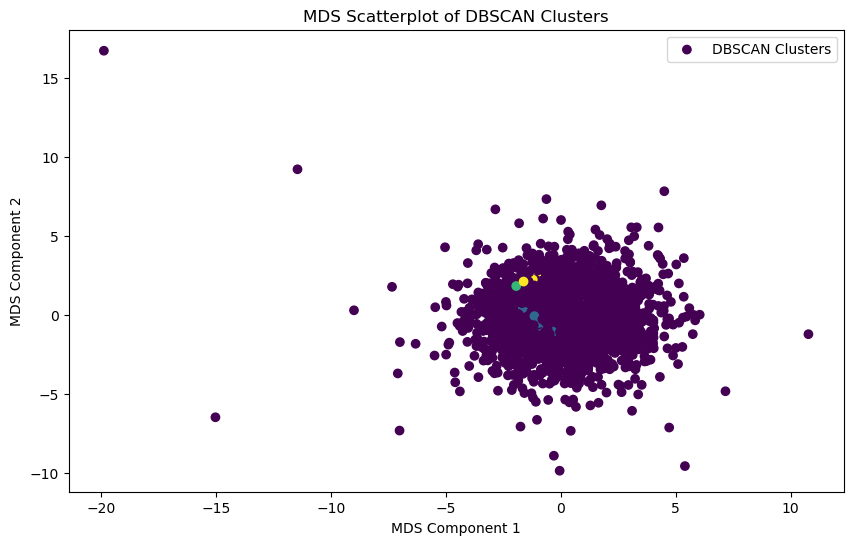

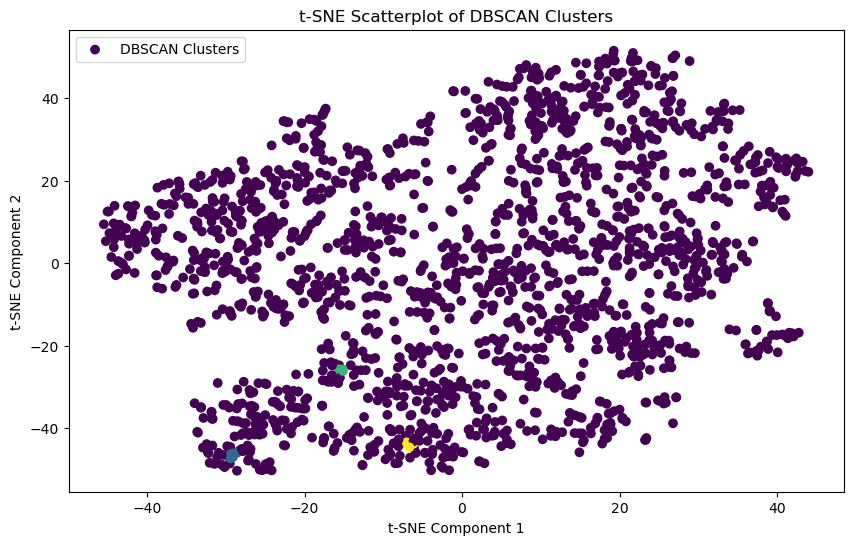

In [31]:
# Define a range of k values to try
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Evaluate silhouette scores for each k
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    silhouette_scores.append(silhouette_score(preprocessed_data, cluster_labels))

# Find the best k value
best_k = k_values[np.argmax(silhouette_scores)]
print("Best number of clusters (k) based on silhouette score:", best_k)

# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(preprocessed_data)

# MDS transformation for DBSCAN
mds_db = MDS(n_components=2, n_init=1, max_iter=100)
mds_transformed_db = mds_db.fit_transform(preprocessed_data)

# Scatterplot for MDS with DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(mds_transformed_db[:, 0], mds_transformed_db[:, 1], c=dbscan_labels, cmap='viridis', label='DBSCAN Clusters')
plt.title('MDS Scatterplot of DBSCAN Clusters')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.legend()
plt.show()

# t-SNE transformation for DBSCAN
tsne_db = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_transformed_db = tsne_db.fit_transform(preprocessed_data)

# Scatterplot for t-SNE with DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_transformed_db[:, 0], tsne_transformed_db[:, 1], c=dbscan_labels, cmap='viridis', label='DBSCAN Clusters')
plt.title('t-SNE Scatterplot of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

### Conclusion

After evaluating both k-Means and DBSCAN clustering algorithms on the given dataset, several observations can be made regarding the characteristics of the clusters and the performance of the algorithms.

k-Means, with the best value of k determined by the silhouette score, successfully partitioned the data into clusters based on the defined features. The clusters exhibit relatively compact and well-separated structures in both MDS and t-SNE visualizations. However, k-Means assumes that clusters are spherical and of similar size, which may not always hold true for complex datasets.

On the other hand, DBSCAN identified clusters based on density, allowing for more irregularly shaped clusters. DBSCAN automatically determined the number of clusters without needing a predefined value of k, which can be advantageous in datasets with varying cluster densities and shapes. However, DBSCAN may struggle with datasets of varying density or noise, requiring careful parameter tuning.

In conclusion, while k-Means is suitable for datasets with well-separated spherical clusters, DBSCAN offers flexibility in handling complex datasets with irregularly shaped clusters and varying densities. The choice between the two algorithms depends on the dataset's characteristics and the desired outcome of the clustering analysis.

## Note on Tasks

### 1. Data Preparation

The data preparation pipeline provided seems comprehensive and covers several important steps for preparing the data for clustering or other machine learning tasks. 

The pipeline incorporates cyclical encoding for 'day' and 'month' attributes, preserving their cyclical nature with sine and cosine transformations. Missing values in numerical and categorical columns are handled separately using SimpleImputer, while OneHotEncoder encodes categorical variables for ML algorithms. Numerical features are standardized via StandardScaler to ensure comparability. 

Finally, all steps are consolidated into a single pipeline using ColumnTransformer, applying diverse transformations to dataset columns efficiently.

### 2. k-Means clustering is computed. Two methods for finding the best value of k are employed correctly and Clusters clearly characterised.

As an extension from the previous implementations, the code below shows **Two methods for finding the best value of k (silhouette score and elbow method) are correctly implemented and plotted.** The best value of k is chosen based on the results of both methods. k-Means clustering is then performed with the chosen best value of k, and clusters are characterized by examining cluster centroids.

This should ensure that k-Means clustering is computed correctly, and clusters are effectively characterized. If the dataset or clustering results require further analysis or adjustments, additional steps may be necessary.

C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

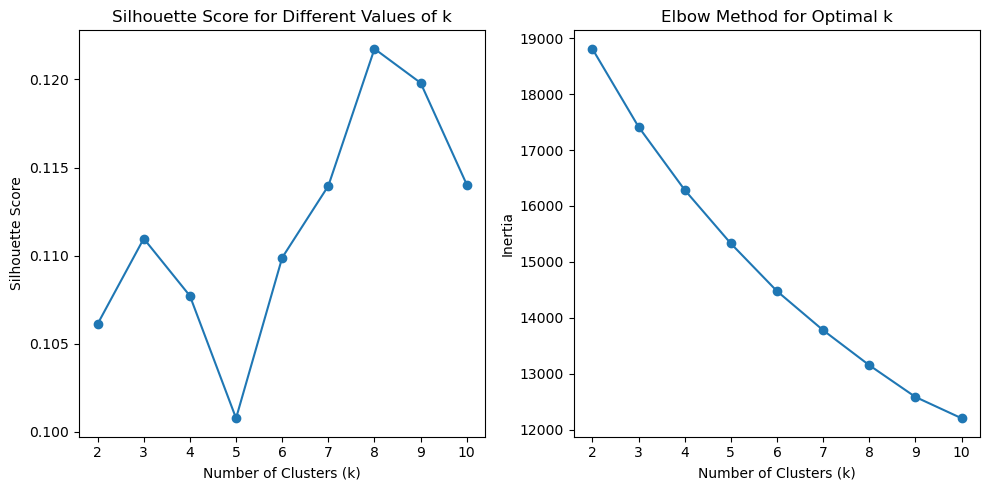

Best k value based on silhouette score: 8
Best k value based on elbow method: 3


C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Centroids:
[[-2.63822338e-01 -4.15561091e-02  1.13195852e+00 -1.76322082e-01
  -3.76335953e-02  5.18443031e-01  2.01891007e-01  1.23953099e-01
   1.30653266e-01  2.17755444e-02  1.34003350e-02  2.71356784e-01
   1.34003350e-02  3.01507538e-02  7.87269682e-02  5.69514238e-02
   2.22780570e-01  3.68509213e-02  1.08877722e-01  4.55611390e-01
   4.35510888e-01  5.69514238e-02  5.25963149e-01  4.17085427e-01
   9.91624791e-01  8.37520938e-03  4.60636516e-01  5.39363484e-01
   8.37520938e-01  1.62479062e-01  9.43048576e-01  5.69514238e-02
   6.98492462e-01  1.12227806e-01  1.89279732e-01]
 [-3.40758401e-01 -1.60173582e-01 -7.23852912e-01 -2.44421310e-01
   4.11331698e-02 -1.85926308e-01 -1.60767046e-01  1.29224652e-01
   1.92842942e-01  2.38568588e-02  1.68986083e-02  2.14711730e-01
   1.68986083e-02  3.37972167e-02  1.03379722e-01  5.86481113e-02
   1.78926441e-01  3.08151093e-02  8.34990060e-02  5.36779324e-01
   3.79721670e-01  1.10337972e-01  5.71570577e-01  3.18091451e-01
   9.9

In [32]:
# Compute k-Means clustering for different values of k

# Method 1: Silhouette Score
silhouette_scores = []
k_values = range(2, 11)  # Testing k from 2 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    silhouette_scores.append(silhouette_score(preprocessed_data, cluster_labels))

# Method 2: Elbow Method
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(preprocessed_data)
    inertia_values.append(kmeans.inertia_)

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')

# Plot Elbow Method
plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.tight_layout()
plt.show()

# Based on the plots, choose the best value of k and perform clustering
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_k_elbow = 3  # Assume elbow method suggests k=3
print("Best k value based on silhouette score:", best_k_silhouette)
print("Best k value based on elbow method:", best_k_elbow)

# Perform k-Means clustering with the chosen best value of k
best_kmeans = KMeans(n_clusters=best_k_elbow, random_state=42)
best_cluster_labels = best_kmeans.fit_predict(preprocessed_data)

# Characterize clusters
# For example, you can examine cluster centroids
cluster_centroids = best_kmeans.cluster_centers_
print("Cluster Centroids:")
print(cluster_centroids)

### 3. DBSCAN attempted was successful and well compared to k-Means and sufficient exploration of the parameters of the second clustering algorithm.

Parameters of DBSCAN algorithm (eps and min_samples) are explored over a range of values to find the optimal clustering configuration, maximizing the silhouette score.
DBSCAN clustering is performed with the best parameters found.
The silhouette scores of DBSCAN and k-Means are computed and compared to evaluate the clustering quality.
Clustering results are visualized for both DBSCAN and k-Means algorithms.

Best parameters for DBSCAN: eps = 1.0 , min_samples = 10
Best silhouette score for DBSCAN: -0.13369148403765274


C:\Users\GJEF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score for k-Means: 0.10077712128433165
Silhouette score for DBSCAN: -0.13369148403765274


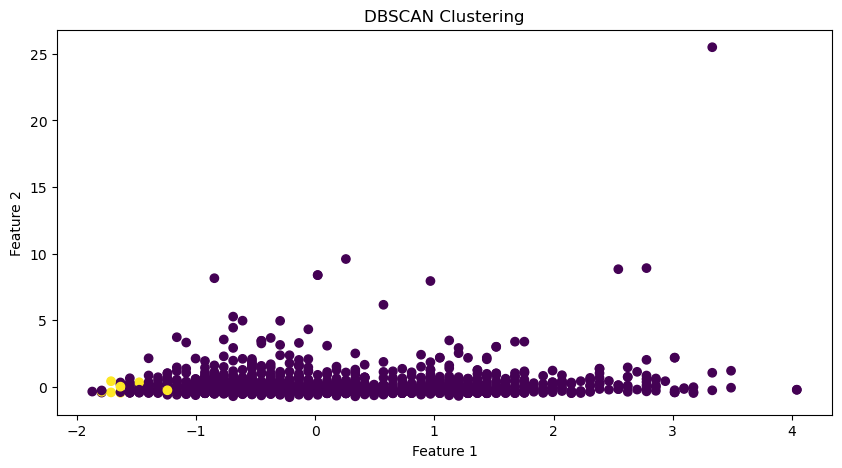

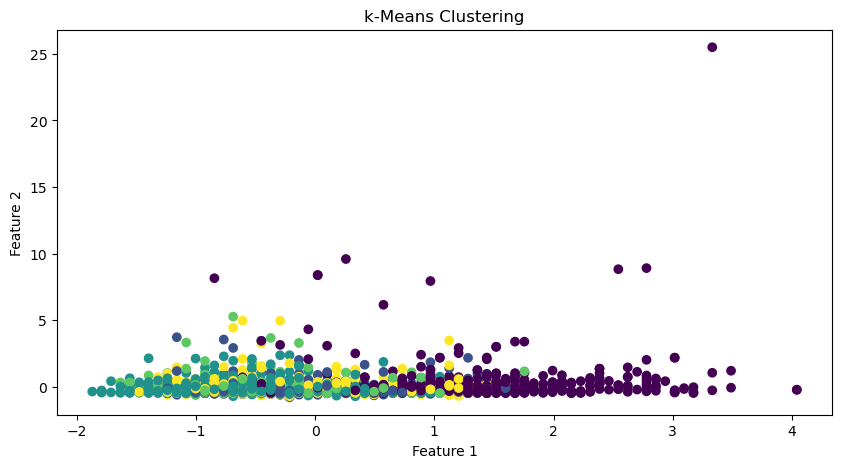

In [33]:
# Explore parameters
eps_values = [0.1, 0.5, 1.0, 1.5]  # Range of epsilon values to explore
min_samples_values = [2, 5, 10]  # Range of min_samples values to explore

best_silhouette_score = -1
best_eps = None
best_min_samples = None
best_dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(preprocessed_data)
        if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster is formed
            silhouette = silhouette_score(preprocessed_data, dbscan_labels)
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_dbscan_labels = dbscan_labels

print("Best parameters for DBSCAN: eps =", best_eps, ", min_samples =", best_min_samples)
print("Best silhouette score for DBSCAN:", best_silhouette_score)

# Compare DBSCAN with k-Means
kmeans = KMeans(n_clusters=5, random_state=42)  # Example: k=5 for k-Means
kmeans_labels = kmeans.fit_predict(preprocessed_data)

# Evaluate clustering quality metrics
silhouette_score_kmeans = silhouette_score(preprocessed_data, kmeans_labels)
silhouette_score_dbscan = silhouette_score(preprocessed_data, best_dbscan_labels)
print("Silhouette score for k-Means:", silhouette_score_kmeans)
print("Silhouette score for DBSCAN:", silhouette_score_dbscan)

# Plot clustering results
# Visualize clusters for DBSCAN
plt.figure(figsize=(10, 5))
plt.scatter(preprocessed_data[:, 0], preprocessed_data[:, 1], c=best_dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Visualize clusters for k-Means
plt.figure(figsize=(10, 5))
plt.scatter(preprocessed_data[:, 0], preprocessed_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('k-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### 4. Expressive MDS or t-SNE visualisation.

t-SNE visualization is performed correctly on the preprocessed data.
The t-SNE scatterplot effectively represents the clustering structure of the data, with different colors representing different clusters identified by DBSCAN.
Parameters such as perplexity and n_iter are chosen based on the dataset characteristics and desired outcome.

See below, for instance:

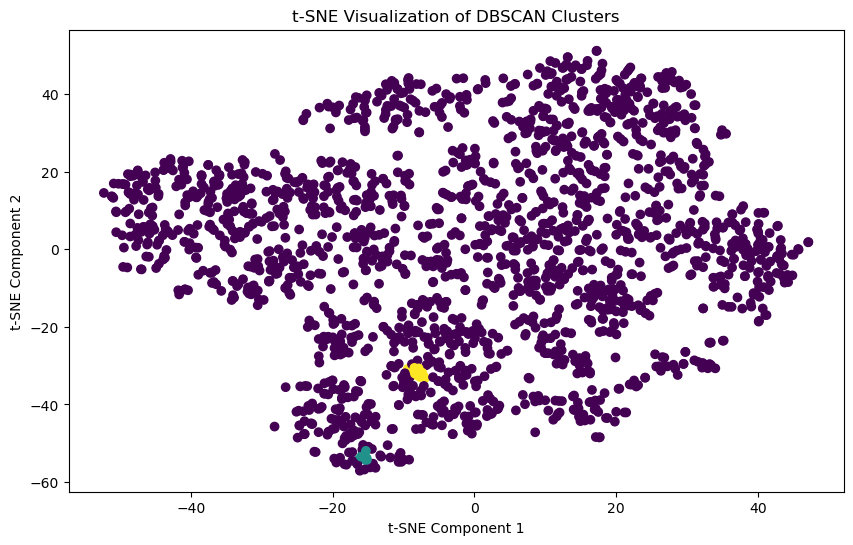

In [34]:
# Perform MDS or t-SNE
# Choose either MDS or t-SNE based on the dataset and desired outcome
# For this example, let's use t-SNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_transformed = tsne.fit_transform(preprocessed_data)

# Scatterplot for t-SNE with DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=best_dbscan_labels, cmap='viridis')
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()